In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy as ccrs
import xarray as xr
from matplotlib import rc
import warnings
warnings.filterwarnings('ignore')
import pickle

In [3]:
large = 28; med = 24; small = 13
params = {'axes.titlesize': small,
          'legend.fontsize': small,
          'figure.figsize': (8, 4),
          'axes.labelsize': small,
          'axes.titlesize': small,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': med,
          'axes.titlepad': 10,
         'axes.facecolor': 'white'} #For electric background plots
plt.rcParams.update(params)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})
# # for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],})

### Functions

In [4]:
### Compute deep layer mean
def dlm(u,pr):
    # input: u_ave[i,:] all the averaged winds in 3deg radius for each level
    # u_ave[lev]: 1x12
    # average from levels 925 to 300 hpa, weighted
    iplow = int(np.where(pr == 925)[0]) # pres index equal to value of 925 
    iptop = int(np.where(pr ==300)[0])
    dp =  int(pr[iptop])-int(pr[iplow])
    ud = 0
    for i in range(iplow,iptop):
        # range plev: 1 to 6
        ud = ud+((u[i+1]+u[i])/2)*np.abs((pr[i+1]-pr[i])/(dp))
    
    return ud

In [5]:
def read_steersq(f):
    
    # u_ave, v_ave: avg wind value in 3-deg radius of storm center, one value per plevel
    # ubt, vbt:  best track “steering flow” at each time step, computed based on the TC 
    # locations in the best track data (one value per time step)

    ds = xr.open_dataset(f)
    lev = ds['lev']
    time = ds['time']
    u_ave = ds['u_ave']
    v_ave = ds['v_ave']
    ubt = ds['ubt']
    vbt = ds['vbt']
    
    return u_ave,v_ave,ubt,vbt,lev

In [6]:
####################################### functions below correct ##################################################
def compute_udir(u,v):
    # u: u_dlm: 20,1 matrix
    # v: v_dlm: 20,1 matrix
    for jj in range(0,len(u)): 
        if u[jj]==0 and v[jj]==0:
            udir[jj] = 0
        else:
            udir = 180/np.pi*np.arctan2(u,v)
            
    # check if udir is negative
    for ii in range(0,len(udir)):
        if udir[ii] < 0:
            udir[ii] = udir[ii] + 360
            
    return udir

def compute_uspeed(u,v):
    # compute magnitude 
    uspeed = np.sqrt(u**2 + v**2)

    return uspeed

def uv2unus(u1,v1,u2,v2): 
    # function to compute 
    
    usp1 = compute_uspeed(u1,v1)
    ud1 = compute_udir(u1,v1)
    usp2 = compute_uspeed(u2,v2)
    ud2 = compute_udir(u2,v2)
    
    ang = ud2-ud1
    us = usp2*np.cos(ang*np.pi/180) # radians units
    un = -1*usp2*np.sin(ang*np.pi/180)
    
    return us, un

## Main 

### Plot and compare steering flow associated with the total pv perturbation and pv perturbations of different systems. e.g. Fig. 6 in Wu et al. 2004


In [11]:
#### 
root = '/archive/twb/pv_inversion/'
# models = ['GFS','IFS','SHiELD_gfsIC','SHiELD_ifsIC']
models_blk = ['SHiELD_ifsIC']
dd = '20170917'
hh = '00'
tags = ['nahigh', 'bhigh', 'ne', 'nw', 'sw', 'se','total']

# assign memory
u_dlm = np.zeros([20, 8]) # 20time, 8comparisons
v_dlm = np.zeros([20, 8])
u_dlm_cntrl = np.zeros([20, 8]) # 20time, 8comparisons
v_dlm_cntrl = np.zeros([20, 8])

j=0 # index for each tag (system)
for model in models_blk:
    for tag in tags:
        if model == 'IFS':
            hh = '0'
            f = root + model + '/' + dd + '_' + hh + '/' + dd + '_' + hh + 'Z_steering_3degree_' + tag + '.nc'
            u_ave,v_ave,ubt,vbt,lev = read_steersq(f)
            
        else:
            hh = '00'
            f = root + model + '/' + dd + hh + '/' + dd + '_' + hh + 'Z_steering_3degree_' + tag + '.nc'
            u_ave,v_ave,ubt,vbt,lev = read_steersq(f)
        
        for i in range(0,20):
            u_dlm[i,j] = dlm(u_ave[i,:],lev)  # u_ave/v_ave[time,lev]
            v_dlm[i,j] = dlm(v_ave[i,:],lev)  # dlm: vert avg u_ave/v_ave for all timesteps
        j=j+1 # increment ind for each system
        print("computing ", tags[j-1]," deep layer mean")
            
    # get TC Best Track data from steering files
u_dlm[:,-1] = ubt[0:len(u_dlm)]
v_dlm[:,-1] = vbt[0:len(v_dlm)]



computing  nahigh  deep layer mean
computing  bhigh  deep layer mean
computing  ne  deep layer mean
computing  nw  deep layer mean
computing  sw  deep layer mean
computing  se  deep layer mean
computing  total  deep layer mean


### Do IFS_analysis for comparison

In [16]:
root = '/archive/twb/pv_inversion/'
models = ['IFS_analysis']
dd = '20170917'
hh = '00'
tags = ['nahigh', 'bhigh', 'ne', 'nw', 'sw', 'se','total']

# assign memory
u_dlm_cntrl = np.zeros([20, 8]) # 20time, 8comparisons
v_dlm_cntrl = np.zeros([20, 8])

j=0 # index for each tag (system)
for model in models:
    for tag in tags:
        if model == 'IFS_analysis':
            hh = '0'
            f = root + model + '/' + dd + '_' + hh + '/' + dd + '_' + hh + 'Z_steering_3degree_' + tag + '.nc'
            u_ave,v_ave,ubt,vbt,lev = read_steersq(f)
            
        else:
            hh = '00'
            f = root + model + '/' + dd + hh + '/' + dd + '_' + hh + 'Z_steering_3degree_' + tag + '.nc'
            u_ave,v_ave,ubt,vbt,lev = read_steersq(f)
        
        for i in range(0,20):
            u_dlm_cntrl[i,j] = dlm(u_ave[i,:],lev)  # u_ave/v_ave[time,lev]
            v_dlm_cntrl[i,j] = dlm(v_ave[i,:],lev)  # dlm: vert avg u_ave/v_ave for all timesteps
        j=j+1 # increment ind for each system
        print("Computing ", tags[j-1]," deep layer mean")
            
    # get TC Best Track data from steering files
u_dlm_cntrl[:,-1] = ubt[0:len(u_dlm_cntrl)]
v_dlm_cntrl[:,-1] = vbt[0:len(v_dlm_cntrl)]

Computing  nahigh  deep layer mean
Computing  bhigh  deep layer mean
Computing  ne  deep layer mean
Computing  nw  deep layer mean
Computing  sw  deep layer mean
Computing  se  deep layer mean
Computing  total  deep layer mean


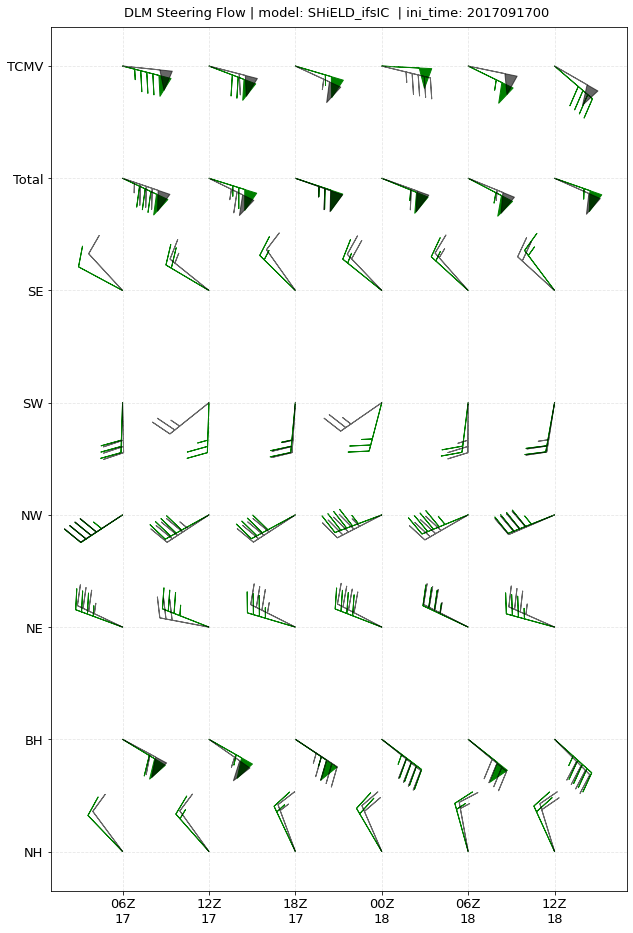

In [70]:
# plot
fig = plt.figure(figsize=(10,15))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# create grid
nx, ny = (20, 8)
x = np.linspace(0, 6, 6)
y = np.linspace(0, 8, ny)
xv, yv = np.meshgrid(x, y)

plt.grid(linestyle='dashed',alpha=0.3)
# plt.xticks(np.arange(0,21,2.5), ['06Z\n17','12Z','24Z','36Z','48Z','60Z','72Z','84Z','96Z'])
# plt.xticks(x, ['06Z\n17','12Z\n17','18Z\n17','00Z\n18','06Z\n18','12Z\n18','18Z\n18',
#                '00Z\n19','06Z\n19','12Z\n19','18Z\n19','00Z\n20','06Z\n20','12Z\n20',
#                '18Z\n20','00Z\n21','06Z\n21','12Z\n21','18Z\n21','00Z\n22'])

plt.xticks(x, ['06Z\n17','12Z\n17','18Z\n17','00Z\n18','06Z\n18','12Z\n18'])

plt.yticks(y, ['NH','BH','NE','NW','SW','SE','Total','TCMV'])
plt.title('DLM Steering Flow | model: '+models_blk[0]+'  | ini_time: 2017091700 ')

# plot barbs on grid
for i in range(0,len(y)):
    plt.barbs(xv[i],yv[i],u_dlm_cntrl[0:6,i],v_dlm_cntrl[0:6,i],length=10,barbcolor='green',barb_increments={'half':0.5,'full':1,'flag':5})
    plt.barbs(xv[i],yv[i],u_dlm[0:6,i],v_dlm[0:6,i],length=10,barb_increments={'half':0.5,'full':1,'flag':5},alpha=0.6) 
ax.set_xlim([-1,7])
fname = '/home/twb/tmp/dlm_steeringflow_zoom_'+models_blk[0]+'.png'
# plt.savefig(fname,dpi=900,facecolor='w',bbox_inches='tight')

### Compute vector projection of each system nondivergent wind on total nondivergent wind (AT)

In [12]:
## create array of AT/CT values
    # AT: parallel component
    # CT: orthogonal component
    
# assign memory
AT = np.zeros([20,6])
CT = np.zeros([20,6])#[time,system]

AT_header = ['NH','BH','NE','NW','SW','SE']

for i in np.arange(0,6):
    AT[:,i] = uv2unus(u_dlm[:,6],v_dlm[:,6],u_dlm[:,i],v_dlm[:,i])[0]
    CT[:,i] = uv2unus(u_dlm[:,6],v_dlm[:,6],u_dlm[:,i],v_dlm[:,i])[1]
    
    AT[:,i] = AT[:,i]/np.sqrt(u_dlm[:,6]**2 + v_dlm[:,6]**2)

### Plot AT for each model

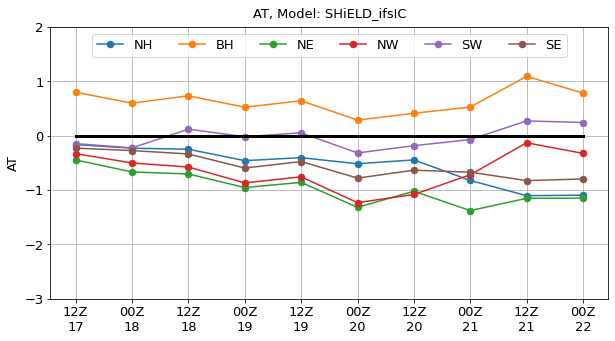

In [13]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

for i in np.arange(0,6):
    plt.plot(AT[1:20:2,i],marker='.',markersize=13,label=AT_header[i])
# plt.plot(np.arange(-1,20.5,0.5),0*np.arange(-1,20.5,0.5),color='k',linewidth=3)
plt.plot(np.arange(0,10,1),0*np.arange(0,10,1),color='k',linewidth=3)

    
# ax.set_xlim(-0.5,19.5)
ax.set_ylim(-3,2)
# plt.xticks(np.arange(0,20,1),['06Z\n17','12Z\n17','18Z\n17','00Z\n18','06Z\n18','12Z\n18','18Z\n18',
#                '00Z\n19','06Z\n19','12Z\n19','18Z\n19','00Z\n20','06Z\n20','12Z\n20',
#                '18Z\n20','00Z\n21','06Z\n21','12Z\n21','18Z\n21','00Z\n22'])
plt.xticks(np.arange(0,10,1),['12Z\n17','00Z\n18','12Z\n18','00Z\n19',
                             '12Z\n19','00Z\n20','12Z\n20','00Z\n21','12Z\n21','00Z\n22'])
#                '00Z\n19','06Z\n19','12Z\n19','18Z\n19','00Z\n20')
ax.set_ylabel('AT',size=13)
plt.title('AT, Model: '+models_blk[0])
ax.legend(loc='upper center',ncol=6)
ax.grid()

fname = '/home/twb/tmp/AT_'+models_blk[0]+'.png'
plt.savefig(fname,dpi=900,facecolor='w',bbox_inches='tight')


### Plot TC translation speed for all models

In [ ]:
root = '/archive/twb/pv_inversion/'
dd = '20170917'
hh = '00'
tag = 'total'
models = ['GFS','IFS','SHiELD_gfsIC','SHiELD_ifsIC']
cols = ['red','blue','green','yellow']

fig = plt.figure(figsize=(15,10))
# ax = fig.add_subplot(211)




    
for i in np.arange(0,len(models)):
    model = models[i]
    
    if model == 'IFS':
        hh ='0'
        f = root + model + '/' + dd + '_' + hh + '/' + dd + '_' + hh + 'Z_steering_3degree_' + tag + '.nc'
    else:
        hh = '00'
        f = root + model + '/' + dd + hh + '/' + dd + '_' + hh + 'Z_steering_3degree_' + tag + '.nc'

    u_ave,v_ave,ubt,vbt,lev = read_steersq(f)
    
    tspd = compute_uspeed(ubt[0:20],vbt[0:20]) # 20,1 array
    

    # compute 12-hr averages of translation speed
    tspd_avg = np.zeros(10)
    tt = 0
    for k in np.arange(1,20,2):
        if k==19:
            tspd_avg[tt] = (tspd[k]+tspd[k-1])/2
        else:
            tspd_avg[tt] = (tspd[k+1]+tspd[k-1])/2
        tt+=1
        
    ax2 = fig.add_subplot(212)
    plt.plot(tspd_avg*(3600/1000),label=models[i],marker='.',markersize=13,color=cols[i])
          
    
    ax1 = fig.add_subplot(211)
    plt.plot(tspd*(3600/1000),label=models[i],marker='.',markersize=13,color=cols[i])

    

ax1 = fig.add_subplot(211)
# ax1.set_ylim([2,8])
plt.xticks(np.arange(0,20,1),['06Z\n17','12Z\n17','18Z\n17','00Z\n18','06Z\n18','12Z\n18','18Z\n18',
               '00Z\n19','06Z\n19','12Z\n19','18Z\n19','00Z\n20','06Z\n20','12Z\n20',
               '18Z\n20','00Z\n21','06Z\n21','12Z\n21','18Z\n21','00Z\n22'])    
plt.legend(ncol=4,loc='upper center')
plt.title('Model Forecast Translation Speed')
ax1.set_ylabel('km/h')
plt.grid()

    
ax2 = fig.add_subplot(212)
ax2.set_ylabel('km/h')
# ax2.set_ylim([0,8])
plt.xticks(np.arange(0,10,1),['12Z\n17','00Z\n18','12Z\n18','00Z\n19','12Z\n19','00Z\n20','12Z\n20',
               '00Z\n21','12Z\n21','00Z\n22'])
plt.legend(ncol=4,loc='upper center')
plt.grid()
plt.title('12hr Average Translation Speed')
plt.subplots_adjust(hspace=0.2)

tspd_avg

In [ ]:
tspd_avg

#### AT: [time,system]
AT size: [20,6]

### Calculate the order (strength) of the steering flows for each time step

In [ ]:
def sorted_flows(AT):
    # order strength of steering flows in descending order
    # input: AT[i,:] parallel components for a single time step
    # AT: 1x6 array [ time, system]
    
    ind=0
    tmp = {}
    for ii in AT:
        tmp[ind]=np.abs(ii) # magnitude of parallel component?
        sorted_values = sorted(tmp.values(),reverse=True)
        sorted_dict = {}
        
        for j in sorted_values: # j: a value 
            for k in tmp.keys(): # k: key
                if tmp[k] == j: # if value equals sorted value
#                     sorted_dict[k] = tmp[k]
                    sorted_dict[tags[k]] = tmp[k]
                    break
        ind+=1
#     print('In descending order (i.e., First system is the strongest)') 
    return sorted_dict

In [ ]:
for i in np.arange(0,20):

    print(i,sorted_flows(AT[i,:]),'\n')
# print(sorted_dict)

### TEST

In [ ]:
sorted_flows(AT[0:2,:])